In [ ]:
pip install pandas PyPDF2 nltk scikit-learn matplotlib gensim scipy==1.10.1   

In [1]:
import os
from PyPDF2 import PdfReader

# Function to extract title and abstract from a PDF
def extract_title_and_abstract(pdf_path):
    with open(pdf_path, 'rb') as f:
        reader = PdfReader(f)
        title = reader.metadata.title

        # To extract the abstract, I use the heurisitc that the abstract is located at the first page
        # It is between the 2 keywords 'Abstract' and 'Introduction'
        # However, there exists papers not following this convention. For those, I store in the "unresolved"
        # and excluded from datasets temporarily
        for page_num in range(1):
            page_text = reader.pages[page_num].extract_text().lower()
            start = page_text.find('abstract') + len("abstract")
            end = page_text.find('introduction')
            if start >= end:
                abstract = ""
            else:
                abstract = page_text[start:end].replace('\n', ' ')

    return title, abstract

In [4]:
# Function to process all PDFs in the given directory
def process_all_pdfs(directory):
    results = []
    unresolved = []
    for filename in os.listdir(directory): 
        if filename.endswith('.pdf'):
            pdf_path = os.path.join(directory, filename)
            title, abstract = extract_title_and_abstract(pdf_path)
            if abstract == "":
                unresolved.append(title)
            else:
                results.append((filename, title, abstract))
    
    return results, unresolved

# The folder contains datasets
directory = os.getcwd() + '/Green Energy Dataset'

extracted_documents, unresolved = process_all_pdfs(directory)
# The format of the successfuly extracted documents is as follows:
# (filename, title, abstract)
print(extracted_documents[0])

('Model_Predictive_Current_Control_of_Nine-Phase_Open-End_Winding_PMSMs_With_an_Online_Virtual_Vector_Synthesis_Strategy.pdf', 'Model Predictive Current Control of Nine-Phase Open-End Winding PMSMs With an Online Virtual Vector Synthesis Strategy', ' —the current error is hard to avoid for ﬁnite control set model predictive current control (fcs-mpcc)in nine-phase open-end winding permanent magnet syn-chronous motors. to overcome this problem, an online vir-tual voltage vector (v 3) synthesis strategy is proposed in this article. first, a group of v3s without harmonic voltage components are designed as the basic vectors for onlinesynthesis. then, two adjacent basic v 3s and a zero vector are used to synthesize a new v3, which can output arbi- trary amplitude and phase angle in the fundamental space.the two basic v 3s are directly selected from the located sector of the predicted reference voltage vector (rvv), andtheir duration ratio can be simply calculated according tothe angle of the

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download stopwords
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize stop words
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Tokenize the text
    words = text.split()

    # Remove stop words and lemmatize
    words = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words]
    return ' '.join(words)

preprocessed_documents = []
for doc in extracted_documents:
    cleaned_abstract = preprocess_text(doc[2])
    preprocessed_documents.append((doc[1], cleaned_abstract))

# The format of a preprocessed document is as follows:
# (paper tile, cleaned abstract)
print(preprocessed_documents[0])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/a1787526/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/a1787526/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


('Model Predictive Current Control of Nine-Phase Open-End Winding PMSMs With an Online Virtual Vector Synthesis Strategy', 'current error hard avoid nite control set model predictive current control fcsmpccin ninephase openend winding permanent magnet synchronous motor overcome problem online virtual voltage vector v synthesis strategy proposed article first group v without harmonic voltage component designed basic vector onlinesynthesis two adjacent basic v zero vector used synthesize new v output arbi trary amplitude phase angle fundamental spacethe two basic v directly selected located sector predicted reference voltage vector rvv andtheir duration ratio simply calculated according tothe angle rvv sector way zeroerror realized new v rvv moreover online pulse generation algorithm corresponding thenew v proposed calculate symmetrical pulse sequence realtime multiphase ow drive system without space vector modulator finally exper imental result veried effectiveness superiority proposed 

In [6]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# Tokenize the articles for Word2Vec
nltk.download('punkt')

# Retrieve an array containing only extracted abstracts
preprocessed_abstracts = [doc[1] for doc in preprocessed_documents]

# Tokenize the abstracts to feed into Word2Vec
tokenized_abstracts = [word_tokenize(article.lower()) for article in preprocessed_abstracts]

# Define parameter values
vector_size_value = 50
window_value = 10
min_count_value = 1

# Train the model
model = Word2Vec(sentences=tokenized_abstracts, vector_size=vector_size_value, window=window_value, min_count=min_count_value, workers=4)

# Get vectors for each article by averaging word vectors
word2vec_vectors = []
for tokens in tokenized_abstracts:
    word_vectors = [model.wv[word] for word in tokens if word in model.wv]
    if word_vectors:
        article_vector = sum(word_vectors) / len(word_vectors)
    else:
        article_vector = [0] * vector_size_value  # Handle empty vectors
    word2vec_vectors.append(article_vector)

[nltk_data] Downloading package punkt to /Users/a1787526/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


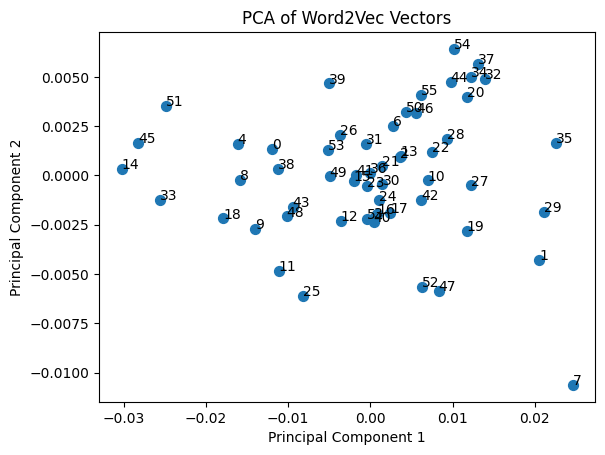

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA to reduce dimensionality for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(word2vec_vectors)

# Visualize the reduced data
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], s=50)
plt.title("PCA of Word2Vec Vectors")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Annotate points with paper titles
# However, the paper titles are long, which makes the figure clumsy
# Therefore, I replace with the index of documents whose abstract is presumably successfully extracted
paper_titles = [title for title, abstract in preprocessed_documents]
for i, title in enumerate(paper_titles):
    plt.annotate(i, (reduced_data[i, 0], reduced_data[i, 1]))
    # plt.annotate(title, (reduced_data[i, 0], reduced_data[i, 1]))

plt.show()

Cluster labels: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0 -1 -1 -1 -1  0 -1 -1
 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1]

Silhouette Score: -0.17272506654262543


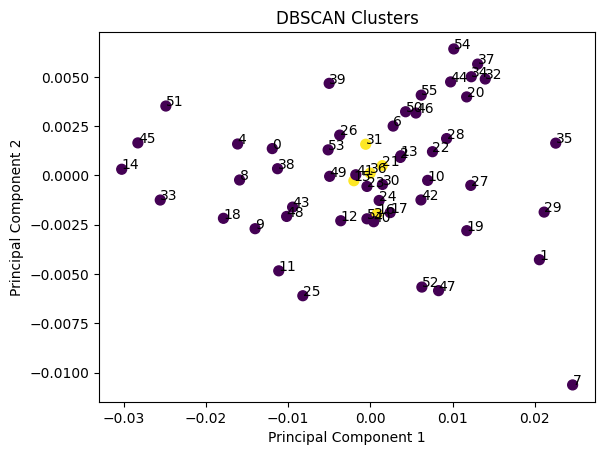

In [8]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Initialize DBSCAN with adjusted parameters
dbscan = DBSCAN(eps=0.01, min_samples=5)  # Adjust eps and min_samples as needed

# Fit DBSCAN to TF-IDF vectors
dbscan.fit(word2vec_vectors)

# Retrieve cluster labels
cluster_labels = dbscan.labels_
print(f"Cluster labels: {cluster_labels}")
print()

# Calculate silhouette score
try:
    silhouette_avg = silhouette_score(word2vec_vectors, cluster_labels)
    print(f"Silhouette Score: {silhouette_avg}")
except:
    print("Unsuccessful clustering")

# Plot the clusters
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, s=50, cmap='viridis')
plt.title("DBSCAN Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

for i, title in enumerate(paper_titles):
    plt.annotate(i, (reduced_data[i, 0], reduced_data[i, 1]))
    
plt.show()


In [11]:
from collections import defaultdict

# Calculating size of each cluster and specifying papers in it
cluster_size = defaultdict(int)
cluster_contents = defaultdict(list)
for i, label in enumerate(cluster_labels):
    cluster_size[label] += 1
    cluster_contents[label].append(i)


# Number of clusters, excluding noise
num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)

print(f"The datasets have : {num_clusters} clusters")
print("Size of each cluster:")
for label, count in cluster_size.items():
    if label != -1:
        print(f"Cluster {label}: {count} papers")
    else:
        print(f"Noise points: {count} papers")


# Generate clustering results
with open("clustering_result.txt", 'w') as file:
    file.write("")

for label, contents in reversed(cluster_contents.items()):
    paper_titles_cluster = [paper_titles[paper_index] if paper_titles[paper_index] else "" for paper_index in contents]
    
    summary = f"Cluster {label} has the following papers:\n" + '\n'.join(paper for paper in paper_titles_cluster if paper) + "\n\n\n\n"
    with open('clustering_result.txt', 'a') as file:
        file.write(summary)


The datasets have : 1 clusters
Size of each cluster:
Noise points: 51 papers
Cluster 0: 5 papers


In [12]:
from collections import Counter

cluster_frequencies = defaultdict(Counter)

for i, label in enumerate(cluster_labels):
    if label != -1:
        words = tokenized_abstracts[i]
        cluster_frequencies[label].update(words)

# Print key terms for each cluster
print("Key terms or topics associated with each cluster:")
for label, word_count in cluster_frequencies.items():
    if label != -1:  # excluding noise points
        top_words_freq = word_count.most_common(10)
        top_words = [word for word, freq in top_words_freq]
        print(f"Cluster {label}: {top_words}")


Key terms or topics associated with each cluster:
Cluster 0: ['energy', 'battery', 'technology', 'storage', 'ee', 'renewable', 'resource', 'environmental', 'demand', 'electrochemical']


<b>SUMMARY REPORT</b>

(based on the figures I obtained. The results from my viewpoint needs a lot of improvements)

<b>The number of cluster: </b>1. <b> Top 10 key terms: </b>'energy', 'battery', 'technology', 'storage', 'ee', 'renewable', 'resource', 'environmental', 'demand', 'electrochemical'
